In [ ]:
import nibabel as nib
import numpy as np

# NIfTI 파일 로드
file_path = '/nas/research/03-Neural_decoding/3-bids/derivatives/normalize/sub-02/betas_session02.nii.gz'
img = nib.load(file_path)
data = img.get_fdata()

print("Shape of the NIfTI image:", data.shape)

# t=1일 때의 볼륨
volume_t1 = data
# 값이 1인 복셀 위치 찾기
indices = np.argwhere(volume_t1 == 1)
print("t=1에서 bold 값이 1인 복셀 개수:", len(indices))



Shape of the NIfTI image: (82, 106, 84, 750)
t=1에서 bold 값이 1인 복셀 개수: 0


In [11]:
import nibabel as nib

# NIfTI 파일 경로
file_path = '/nas/research/03-Neural_decoding/3-bids/raw_data/sub-01/ses-01/anat/sub-01_ses-01_T1w.nii.gz'  # 또는 .nii

# 파일 로드
img = nib.load(file_path)

# 데이터 배열 추출
data = img.get_fdata()

# shape 출력
print("Shape of the NIfTI image:", data.shape)


Shape of the NIfTI image: (208, 300, 320)


In [ ]:
import nibabel as nib
import numpy as np

# 파일 경로
beta_path = '/nas/research/03-Neural_decoding/3-bids/derivatives/normalize/sub-01/betas_session03.nii.gz'

# 데이터 로드
beta_img = nib.load(beta_path)
beta_data = beta_img.get_fdata()  # shape: (x, y, z, t)

# t=1 (두 번째 timepoint)의 3D 볼륨
volume_t1 = beta_data[..., 1]  # shape: (x, y, z)

# 값이 0이 아닌 (x, y, z) 좌표의 개수 세기
non_zero_voxel_count = np.count_nonzero(volume_t1)

print(f"✅ t=1에서 intensity가 0이 아닌 복셀 수: {non_zero_voxel_count}")


In [5]:
import nibabel as nib
import numpy as np

# 파일 경로
beta_path = '/nas/research/03-Neural_decoding/3-bids/derivatives/normalize/sub-01/betas_session03.nii.gz'

# NIfTI 파일 로드
img = nib.load(beta_path)
data = img.get_fdata()  # shape: (x, y, z, t)

# 원하는 위치 지정
x, y, z, t = 35, 26, 40, 1  # 예: ITK-SNAP에서 본 좌표

# intensity 출력
value = data[x, y, z, t]
print(f"📍 Intensity at (x={x}, y={y}, z={z}, t={t}): {value}")


📍 Intensity at (x=35, y=26, z=40, t=1): 0.0


In [3]:
# beta파일 bids 형식으로 만들기
import os
import re
import shutil

# 원본 루트 폴더
root_dir = "/nas/research/03-Neural_decoding/3-bids/derivatives/b4_roi"
# 새로운 저장 루트 (BIDS 형식으로 저장할 곳)
output_dir = "/nas/research/03-Neural_decoding/3-bids/derivatives/b4_roi2"

os.makedirs(output_dir, exist_ok=True)

for subject_folder in os.listdir(root_dir):
    subject_path = os.path.join(root_dir, subject_folder)
    if os.path.isdir(subject_path) and subject_folder.startswith("sub-"):
        subject_id = subject_folder.split("-")[1]

        for filename in os.listdir(subject_path):
            if filename.startswith("betas_session") and filename.endswith(".nii.gz"):
                session_match = re.search(r'session(\d+)', filename)
                if session_match:
                    session_num = session_match.group(1).zfill(2)
                    desc = "betaroi"  # 파일 이름
                    new_filename = f"sub-{subject_id}_ses-{session_num}_desc-{desc}.nii.gz"

                    bids_sub_dir = os.path.join(output_dir, f"sub-{subject_id}", f"ses-{session_num}", "func")
                    os.makedirs(bids_sub_dir, exist_ok=True)

                    src_file = os.path.join(subject_path, filename)
                    dst_file = os.path.join(bids_sub_dir, new_filename)
                    shutil.copy2(src_file, dst_file)

In [ ]:
#_rest_ -> _task-rest_ 로 파일들 이름 바꾸기
import os

def rename_rest_to_task_rest(root_dir):
    """
    주어진 root_dir 안의 모든 폴더를 순회하면서
    파일명에 '_rest_'가 포함된 경우 '_task-rest_'로 변경합니다.
    """
    for dirpath, dirnames, filenames in os.walk(root_dir):
        for filename in filenames:
            if "_rest_" in filename:
                old_path = os.path.join(dirpath, filename)
                new_filename = filename.replace("_rest_", "_task-rest_")
                new_path = os.path.join(dirpath, new_filename)
                
                # 이름 변경
                os.rename(old_path, new_path)
                print(f"Renamed:\n  {old_path}\n→ {new_path}\n")

if __name__ == "__main__":
    # 여기다가 최상위 폴더 경로 입력
    root_directory = "/nas/research/03-Neural_decoding/3-bids/raw_data/sub-08"  # <-- 여기를 네 데이터 폴더로 바꿔
    rename_rest_to_task_rest(root_directory)


In [1]:
import os
import json

# 비교 대상이 되는 root directory 경로
root_dir = '/nas/research/03-Neural_decoding/3-bids/raw_data'

# 대상 subject
subject = 'sub-06'

# 비교에 사용할 주요 파라미터 키
keys_to_compare = ['RepetitionTime', 'EchoTime', 'SliceTiming', 'PixelSpacing', 'PhaseEncodingDirection']

# 결과 저장용
params_by_file = {}

# 파일 탐색 및 파라미터 수집
for dirpath, dirnames, filenames in os.walk(os.path.join(root_dir, subject)):
    for fname in filenames:
        if fname.endswith('_bold.json'):
            fpath = os.path.join(dirpath, fname)
            with open(fpath, 'r') as f:
                metadata = json.load(f)
                key_info = {k: metadata.get(k, 'MISSING') for k in keys_to_compare}
                params_by_file[fpath] = key_info

# 비교 결과 출력
print(f"\n[{subject}] BOLD JSON 파라미터 비교 결과:")
for fpath, param in sorted(params_by_file.items()):
    print(f"\n▶ {fpath}")
    for k, v in param.items():
        print(f"  - {k}: {v}")



[sub-06] BOLD JSON 파라미터 비교 결과:

▶ /nas/research/03-Neural_decoding/3-bids/raw_data/sub-06/ses-01/func/sub-06_ses-01_task-image_run-01_bold.json
  - RepetitionTime: 1.6
  - EchoTime: 0.022
  - SliceTiming: [0, 0.745, 1.49, 0.63, 1.375, 0.515, 1.2625, 0.4, 1.1475, 0.285, 1.0325, 0.1725, 0.9175, 0.0575, 0.8025, 1.5475, 0.6875, 1.4325, 0.5725, 1.3175, 0.4575, 1.205, 0.3425, 1.09, 0.23, 0.975, 0.115, 0.86, 0, 0.745, 1.49, 0.63, 1.375, 0.515, 1.2625, 0.4, 1.1475, 0.285, 1.0325, 0.1725, 0.9175, 0.0575, 0.8025, 1.5475, 0.6875, 1.4325, 0.5725, 1.3175, 0.4575, 1.205, 0.3425, 1.09, 0.23, 0.975, 0.115, 0.86, 0, 0.745, 1.49, 0.63, 1.375, 0.515, 1.2625, 0.4, 1.1475, 0.285, 1.0325, 0.1725, 0.9175, 0.0575, 0.8025, 1.5475, 0.6875, 1.4325, 0.5725, 1.3175, 0.4575, 1.205, 0.3425, 1.09, 0.23, 0.975, 0.115, 0.86]
  - PixelSpacing: MISSING
  - PhaseEncodingDirection: j-

▶ /nas/research/03-Neural_decoding/3-bids/raw_data/sub-06/ses-01/func/sub-06_ses-01_task-image_run-02_bold.json
  - RepetitionTime: 1.6
  

In [7]:
import nibabel as nib
import numpy as np
import os
import glob

# 폴더 경로 설정
folder_path = '/nas/research/03-Neural_decoding/3-bids/raw_data/sub-01/ses-01/func'  # 수정 필요

# nii.gz 파일들만 가져오기
nii_files = sorted(glob.glob(os.path.join(folder_path, '*.nii.gz')))

# 총 timepoints 계산
total_timepoints = 0
for f in nii_files:
    img = nib.load(f)
    shape = img.shape
    if len(shape) < 4:
        raise ValueError(f"File {f} does not have 4D shape: got {shape}")
    timepoints = shape[-1]
    total_timepoints += timepoints
    print(f"{os.path.basename(f)}: timepoints = {timepoints}")

print(f"\nTotal timepoints across all files: {total_timepoints}")


sub-01_ses-01_task-image_run-01_bold.nii.gz: timepoints = 188
sub-01_ses-01_task-image_run-02_bold.nii.gz: timepoints = 188
sub-01_ses-01_task-image_run-03_bold.nii.gz: timepoints = 188
sub-01_ses-01_task-image_run-04_bold.nii.gz: timepoints = 188
sub-01_ses-01_task-image_run-05_bold.nii.gz: timepoints = 188
sub-01_ses-01_task-image_run-06_bold.nii.gz: timepoints = 188
sub-01_ses-01_task-image_run-07_bold.nii.gz: timepoints = 188
sub-01_ses-01_task-image_run-08_bold.nii.gz: timepoints = 188
sub-01_ses-01_task-image_run-09_bold.nii.gz: timepoints = 188
sub-01_ses-01_task-image_run-10_bold.nii.gz: timepoints = 188
sub-01_ses-01_task-image_run-11_bold.nii.gz: timepoints = 188
sub-01_ses-01_task-image_run-12_bold.nii.gz: timepoints = 188

Total timepoints across all files: 2256


Mean: 0.0001
Std: 0.7279


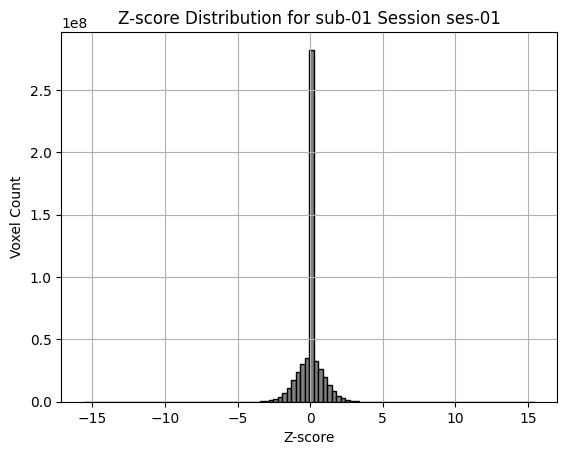

In [8]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

file_path = f'/nas/research/03-Neural_decoding/3-bids/derivatives/new_b4_roi_zscore/sub-01/ses-01/func/sub-01_ses-01_desc-betaroizscore.nii.gz'

# 파일 존재 확인
if not os.path.exists(file_path):
    raise FileNotFoundError(f"{file_path} 파일이 존재하지 않습니다.")

# 파일 불러오기
img = nib.load(file_path)
data = img.get_fdata()

# NaN, Inf 등 제거 (안전성 확보)
data = np.nan_to_num(data)

# 1D 벡터로 변환 (히스토그램을 그리기 위함)
flattened_data = data.flatten()

# 평균과 표준편차 계산
mean = np.mean(flattened_data)
std = np.std(flattened_data)

# 출력
print(f"Mean: {mean:.4f}")
print(f"Std: {std:.4f}")

# 분포 그래프 (히스토그램)
plt.hist(flattened_data, bins=100, color='gray', edgecolor='black')
plt.title(f"Z-score Distribution for sub-01 Session ses-01")
plt.xlabel("Z-score")
plt.ylabel("Voxel Count")
plt.grid(True)
plt.show()


In [14]:
import nibabel as nib
import numpy as np

# z-score 정규화된 fMRI 파일
zscore_file = '/nas/research/03-Neural_decoding/3-bids/derivatives/new_b4_roi_zscore/sub-01/ses-01/func/sub-01_ses-01_desc-betaroizscore.nii.gz'
# 마스크 파일
mask_file = '/nas/research/03-Neural_decoding/3-bids/derivatives/b4_roi_zscore/sub-01/sub-01_nsdgeneral.nii.gz'

# 데이터 로딩
zdata = nib.load(zscore_file).get_fdata()  # shape: (X, Y, Z, T)
mask = nib.load(mask_file).get_fdata() > 0  # shape: (X, Y, Z), boolean

# 시간축 기준 voxel-wise 평균/표준편차 계산 → shape: (X, Y, Z)
voxel_means = np.mean(zdata, axis=-1)
voxel_stds = np.std(zdata, axis=-1)

# 마스크 영역만 골라서 평균 계산
mean_of_means = np.mean(voxel_means[mask])
mean_of_stds = np.mean(voxel_stds[mask])

print(f"[Voxel-wise] 마스크 영역 평균들의 평균: {mean_of_means:.4f}")
print(f"[Voxel-wise] 마스크 영역 표준편차들의 평균: {mean_of_stds:.4f}")




[Voxel-wise] 마스크 영역 평균들의 평균: 0.0000
[Voxel-wise] 마스크 영역 표준편차들의 평균: 1.0000


In [18]:
import os
import nibabel as nib
from glob import glob

base_dir = '/nas/research/03-Neural_decoding/3-bids/raw_data/sub-01'
total_timepoints = 0

for ses_num in range(1, 2):
    ses_id = f"ses-{ses_num:02d}"
    func_dir = os.path.join(base_dir, ses_id, 'func')

    # bold 파일들 찾기
    bold_files = glob(os.path.join(func_dir, '*_bold.nii.gz'))

    for bold_file in bold_files:
        try:
            img = nib.load(bold_file)
            shape = img.shape
            last_dim = shape[-1]
            print(f"{bold_file} → shape: {shape}")
            total_timepoints += last_dim
        except Exception as e:
            print(f"[ERROR] {bold_file}: {e}")

print(f"\n총 timepoints (shape[-1] 합): {total_timepoints}")


/nas/research/03-Neural_decoding/3-bids/raw_data/sub-01/ses-01/func/sub-01_ses-01_task-image_run-01_bold.nii.gz → shape: (120, 120, 84, 188)
/nas/research/03-Neural_decoding/3-bids/raw_data/sub-01/ses-01/func/sub-01_ses-01_task-image_run-12_bold.nii.gz → shape: (120, 120, 84, 188)
/nas/research/03-Neural_decoding/3-bids/raw_data/sub-01/ses-01/func/sub-01_ses-01_task-image_run-02_bold.nii.gz → shape: (120, 120, 84, 188)
/nas/research/03-Neural_decoding/3-bids/raw_data/sub-01/ses-01/func/sub-01_ses-01_task-image_run-03_bold.nii.gz → shape: (120, 120, 84, 188)
/nas/research/03-Neural_decoding/3-bids/raw_data/sub-01/ses-01/func/sub-01_ses-01_task-image_run-04_bold.nii.gz → shape: (120, 120, 84, 188)
/nas/research/03-Neural_decoding/3-bids/raw_data/sub-01/ses-01/func/sub-01_ses-01_task-image_run-05_bold.nii.gz → shape: (120, 120, 84, 188)
/nas/research/03-Neural_decoding/3-bids/raw_data/sub-01/ses-01/func/sub-01_ses-01_task-image_run-06_bold.nii.gz → shape: (120, 120, 84, 188)
/nas/research